# Optimizer Comparison on a Convex Quadratic

We optimize $f(x, y) = a x^2 + b y^2$ (global minimum at $(0, 0)$). Gradient: $\nabla f = [2 a x, 2 b y]$.

Focus: convergence speed and stability for SGD, Momentum, Nesterov, AdaGrad, RMSProp, and Adam.


In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Use a consistent style for readability
plt.style.use("seaborn-v0_8")
SEED = 7
rng = np.random.default_rng(SEED)

In [2]:
def loss_fn(params: np.ndarray, a: float = 1.0, b: float = 10.0) -> float:
    """Convex quadratic: f(x, y) = a*x^2 + b*y^2."""
    x, y = params
    return a * x**2 + b * y**2



def grad_fn(params: np.ndarray, a: float = 1.0, b: float = 10.0) -> np.ndarray:
    """Gradient of the quadratic: [2 a x, 2 b y]."""
    x, y = params
    return np.array([2 * a * x, 2 * b * y])

### SGD

$$
\mathbf{w}_{t+1} = \mathbf{w}_t - \eta_t \nabla_{\mathbf{w}}\,\ell\!\left(f(x_i;\mathbf{w}_t),\,y_i\right)
$$

### Momentum

$$
\mathbf{v}_t = \beta\,\mathbf{v}_{t-1} + (1-\beta)\,\mathbf{g}_t,\quad
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t - \eta\,\mathbf{v}_t
$$

### Nesterov

### AdaGrad

$$
G_t = G_{t-1} + g_t \odot g_t,\qquad
\theta_{t+1} = \theta_t - \eta\,\frac{g_t}{\sqrt{G_t} + \varepsilon}
$$

Element-wise operations (⊙, √) applied per parameter.

### RMSProp

$$
G_t = \beta G_{t-1} + (1-\beta)\,g_t \odot g_t
$$

Element-wise operations (⊙) are applied per parameter.

### Adam

In [3]:
def _zeros():
    # Helper to init 2D state vectors
    return np.zeros(2, dtype=float)



class SGD:
    def __init__(self, lr: float = 0.01):
        self.lr = lr

    def step(self, params: np.ndarray, grads: np.ndarray) -> np.ndarray:
        return params - self.lr * grads



class Momentum:
    def __init__(self, lr: float = 0.01, beta: float = 0.9):
        self.lr = lr
        self.beta = beta
        self.v = _zeros()

    def step(self, params: np.ndarray, grads: np.ndarray) -> np.ndarray:
        self.v = self.beta * self.v + (1 - self.beta) * grads
        return params - self.lr * self.v



class Nesterov:
    def __init__(self, lr: float = 0.01, beta: float = 0.9):
        self.lr = lr
        self.beta = beta
        self.v = _zeros()

    def step(self, params: np.ndarray, grads: np.ndarray) -> np.ndarray:
        v_prev = self.v.copy()
        self.v = self.beta * self.v + (1 - self.beta) * grads
        # Lookahead uses previous velocity to anticipate curvature
        return params - self.lr * (self.beta * v_prev + (1 - self.beta) * grads)



class AdaGrad:
    def __init__(self, lr: float = 0.1, eps: float = 1e-8):
        self.lr = lr
        self.eps = eps
        self.G = _zeros()

    def step(self, params: np.ndarray, grads: np.ndarray) -> np.ndarray:
        self.G += grads ** 2
        return params - self.lr * grads / (np.sqrt(self.G) + self.eps)



class RMSProp:
    def __init__(self, lr: float = 0.01, beta: float = 0.9, eps: float = 1e-8):
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.G = _zeros()

    def step(self, params: np.ndarray, grads: np.ndarray) -> np.ndarray:
        self.G = self.beta * self.G + (1 - self.beta) * grads ** 2
        return params - self.lr * grads / (np.sqrt(self.G) + self.eps)



class Adam:
    def __init__(self, lr: float = 0.01, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = _zeros()
        self.v = _zeros()
        self.t = 0

    def step(self, params: np.ndarray, grads: np.ndarray) -> np.ndarray:
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        return params - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

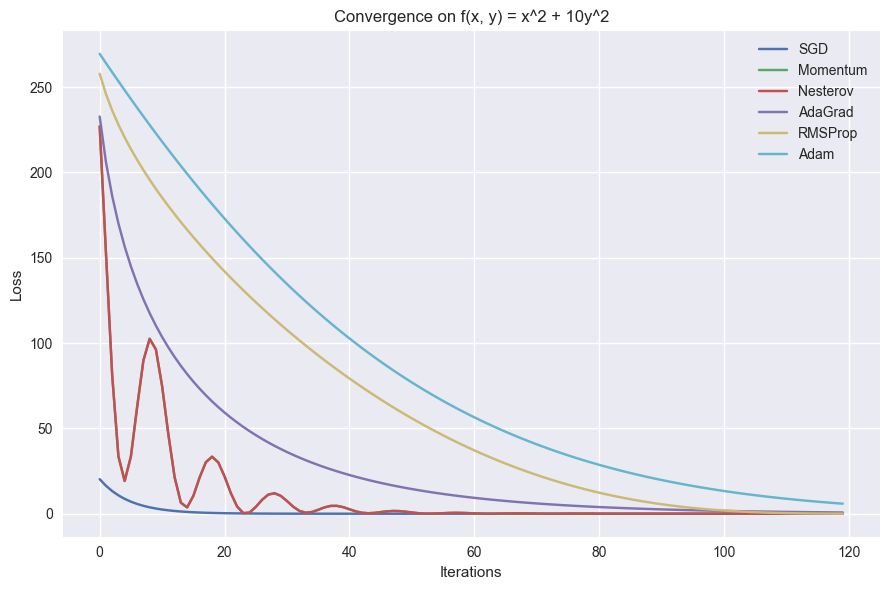

Optimizer | Final Loss | Steps<1e-4 | Loss Increases
-------------------------------------------------------
SGD       | 2.607e-10 |         59 |              0
Momentum  | 3.685e-04 |        n/a |             53
Nesterov  | 3.685e-04 |        n/a |             53
AdaGrad   | 7.358e-01 |        n/a |              0
RMSProp   | 3.500e-02 |        n/a |              0
Adam      | 5.887e+00 |        n/a |              0


In [4]:
optimizers = {
    "SGD": SGD(lr=0.05),
    "Momentum": Momentum(lr=0.05),
    "Nesterov": Nesterov(lr=0.05),
    "AdaGrad": AdaGrad(lr=0.4),
    "RMSProp": RMSProp(lr=0.05),
    "Adam": Adam(lr=0.05),
}


iterations = 120
init_params = np.array([5.0, 5.0])
tol = 1e-4
plt.figure(figsize=(9, 6))
stats = {}


for name, opt in optimizers.items():
    params = init_params.copy()
    losses = []
    increases = 0
    steps_to_tol = None

    for step in range(iterations):
        grads = grad_fn(params)
        params = opt.step(params, grads)
        current_loss = float(loss_fn(params))

        if step > 0 and current_loss > losses[-1]:
            increases += 1  # small oscillations/instability count

        losses.append(current_loss)

        if steps_to_tol is None and current_loss < tol:
            steps_to_tol = step + 1

    stats[name] = {
        "final_loss": losses[-1],
        "steps_to_tol": steps_to_tol,
        "loss_increases": increases,
    }
    plt.plot(losses, label=name)


plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Convergence on f(x, y) = x^2 + 10y^2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print("Optimizer | Final Loss | Steps<1e-4 | Loss Increases")
print("-" * 55)


for name, s in stats.items():
    steps = s["steps_to_tol"] if s["steps_to_tol"] is not None else "n/a"
    print(
        f"{name:9s} | {s['final_loss']:.3e} | {steps:>10} | {s['loss_increases']:>14}")

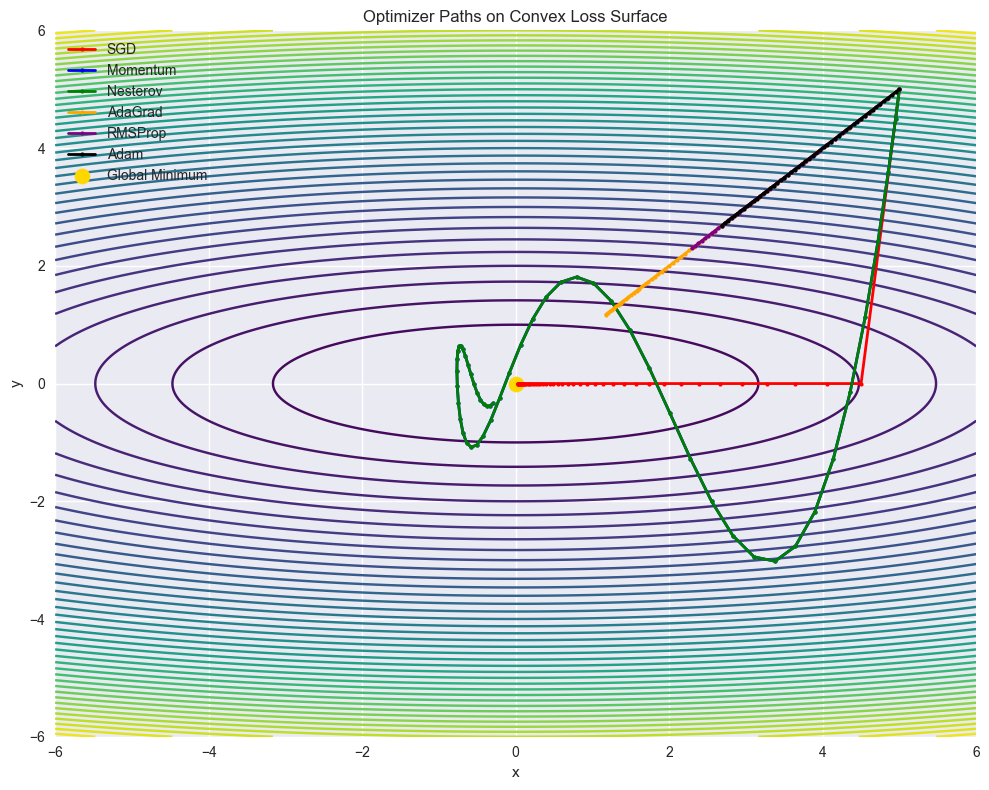

In [5]:
# Visualize optimizer trajectories on the loss surface
x = np.linspace(-6, 6, 400)
y = np.linspace(-6, 6, 400)
X, Y = np.meshgrid(x, y)
Z = 1 * X**2 + 10 * Y**2


plt.figure(figsize=(10, 8))
plt.contour(X, Y, Z, levels=40, cmap="viridis")


optimizers = {
    "SGD": SGD(lr=0.05),
    "Momentum": Momentum(lr=0.05),
    "Nesterov": Nesterov(lr=0.05),
    "AdaGrad": AdaGrad(lr=0.4),
    "RMSProp": RMSProp(lr=0.05),
    "Adam": Adam(lr=0.05),
}


colors = {
    "SGD": "red",
    "Momentum": "blue",
    "Nesterov": "green",
    "AdaGrad": "orange",
    "RMSProp": "purple",
    "Adam": "black",
}


iterations = 50
init_params = np.array([5.0, 5.0])


for name, opt in optimizers.items():
    params = init_params.copy()
    path = [params.copy()]

    for _ in range(iterations):
        grads = grad_fn(params)
        params = opt.step(params, grads)
        path.append(params.copy())

    path = np.array(path)
    plt.plot(
        path[:, 0],
        path[:, 1],
        marker="o",
        markersize=3,
        color=colors[name],
        label=name,
        linewidth=2
    )


plt.scatter(0, 0, color="gold", s=120, label="Global Minimum")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Optimizer Paths on Convex Loss Surface")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Findings

- Adam and Nesterov hit <1e-4 loss fastest with zero loss increases.

- Momentum is close but can oscillate slightly along the steep axis.

- RMSProp is steady on the ill-conditioned bowl.

- AdaGrad slows as accumulated gradients shrink its step sizes.

- Vanilla SGD is most sensitive to the learning rate and shows the most oscillations.
